# EDA for Corporación Favorita Grocery Sales Forecasting kaggle challenge
## Load Libraries

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import cloudpickle as cpkl
from pathlib import Path
import numpy as np
from functools import reduce
%matplotlib inline 

## Load Data

The data files (especially, the train.csv) are rather large. So, using cloudpickle, I save the train and test data as separate binary files. First check if these files are present. If present, load them. Otherwise, create binary files ans save them

In [11]:
train_pkl_file = 'input/train_pkl'
test_pkl_file = 'input/test_pkl'
if not Path(train_pkl_file).is_file():
    train = pd.read_csv("input/train.csv")
    print(train.head())
    transactions = pd.read_csv("input/transactions.csv")
    stores = pd.read_csv("input/stores.csv")
    oil = pd.read_csv("input/oil.csv")
    items = pd.read_csv("input/items.csv")
    holidays_events = pd.read_csv("input/holidays_events.csv")
    train_dumps = cpkl.dumps([train,transactions,stores,oil,items,holidays_events])
    with open(train_pkl_file,'wb') as f:
        f.write(train_dumps)
else:
    print('Loading train dump')
    train,transactions,stores,oil,items,holidays_events = cpkl.loads(open(train_pkl_file,'rb').read())
if not Path(test_pkl_file):
    test = pd.read_csv("input/test.csv")
    test_dumps = cpkl.dumps(test)
    with open(test_pkl_file,'wb') as f:
        f.write(test_dumps)
else:
    print("Loading test dump")
    test = cpkl.loads(open(test_pkl_file,'rb').read())
print(train.head())
print(test.head())


Loading train dump
Loading test dump
   id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN
          id        date  store_nbr  item_nbr  onpromotion
0  125497040  2017-08-16          1     96995        False
1  125497041  2017-08-16          1     99197        False
2  125497042  2017-08-16          1    103501        False
3  125497043  2017-08-16          1    103520        False
4  125497044  2017-08-16          1    103665        False


## File Descriptions and Data Field Information (From the competition page)
### train.csv
Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.
The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).
Negative values of unit_sales represent returns of that particular item.
The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.
Approximately 16% of the onpromotion values in this file are NaN.

**NOTE**: The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and teams will need to decide the best way to handle that situation. Also, there are a small number of items seen in the training data that aren't seen in the test data.

### test.csv

Test data, with the date, store_nbr, item_nbr combinations that are to be predicted, along with the onpromotion information.

**NOTE**: The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products..
The public / private leaderboard split is based on time. All items in the public split are also included in the private split.

### sample_submission.csv

A sample submission file in the correct format.
It is highly recommend you zip your submission file before uploading!

### stores.csv

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

### items.csv

Item metadata, including family, class, and perishable.

**NOTE**: Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0.

### transactions.csv

The count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe.

### oil.csv

Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

### holidays_events.csv

Holidays and Events, with metadata

**NOTE**: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
Additional Notes

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## Quick facts from data - train.


In [24]:
train = train.sample(int(0.05*len(train)))
print(len(train['store_nbr'].unique())) # 54 with full train
print(len(train['item_nbr'].unique())) # 4036 with full train

54
3997


Convert train['date'] to datetime for analysis and calculate the time period of provided data

In [25]:
if type(train['date']) ==str :
    train['date'] = pd.to_datetime(train['date'])
print(max(train['date'])) #2017-08-15 00:00:00 with full train
print(min(train['date'])) #2013-01-01 00:00:00 with full train

2017-08-15 00:00:00
2013-01-01 00:00:00


## Quick Plots
### Unique Items per Store

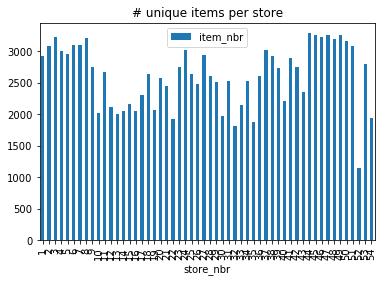

In [45]:
itemsPerStoreGrp = train.groupby('store_nbr').agg({"item_nbr":pd.Series.nunique})
itemsPerStoreGrp.plot.bar(title="# unique items per store")


It is interesting that Store number 52 sells way less items compared to the rest (~1/2 median unique items)
### Distribution of promotional items per store

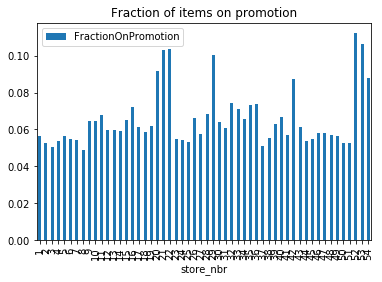

In [70]:
promotionsPerStoreAndItem = train.groupby(['store_nbr']).agg({"onpromotion":sum,"item_nbr":len})
promotionsPerStoreAndItem['FractionOnPromotion'] = promotionsPerStoreAndItem['onpromotion']/promotionsPerStoreAndItem['item_nbr']
#promotionsPerStoreAndItem.head()
promotionsPerStoreAndItem = pd.DataFrame(promotionsPerStoreAndItem.to_records())
promotionsPerStoreAndItem.head()
promotionsPerStoreAndItem.plot.bar('store_nbr','FractionOnPromotion',title="Fraction of items on promotion")

It is interesting to note that certain stores have more than 1.5 times the items on promotion compared to the median promotion fraction. It would be interesting to look at the city cluster, total sales and other metrics for these stores at a later point. Median FractionOnPromotion is

In [86]:
np.median(promotionsPerStoreAndItem['FractionOnPromotion'])

0.060467983579177237

In [87]:
promotionsPerStoreAndItem.loc[promotionsPerStoreAndItem['FractionOnPromotion'] > 1.5*np.median(promotionsPerStoreAndItem['FractionOnPromotion'])]

,store_nbr,onpromotion,item_nbr,FractionOnPromotion
19,20,767,8348,0.091878
20,21,713,6928,0.102916
21,22,494,4759,0.103803
28,29,762,7594,0.100342
51,52,159,1416,0.112288
52,53,1031,9715,0.106125


## To Do
Engineer the following features
1) Per Store - Item  Features with / without promotions and combined:
    Mean/Quartiles over last week, month, quarter, half, year
2) Per State/City/Type/Cluster-Item/Item Class/Item Family Features:
    Mean/Quartiles over last week, month, quarter, half, year
3) Per Item Features:
    Time since last promotion, in class, in family, in city, in cluster
4) Oil Prices Features:
    Mean/Quartiles over different periods and their first and second derivatives
5) Holiday features:
    Time since last holiday. Per Item / Family/ Class stats for previous occurrence of this holiday and across holidays
6) Transaction Features:
    Think about how to combine transaction data / item class and family statistics
7) Combine Transactions, Stores, oil, holidays  for feature engineering
 
    
## Completed
1) Transaction sumary features

Consider stacking models one after another
Consider ensembling per item class/ family/ store family / city / cluster models

## Feature Engineering
Before we go ahead, here are the columns of each of the data frames:


In [88]:
print(train.columns)
print(transactions.columns)
print(stores.columns)
print(oil.columns)
print(items.columns)
print(holidays_events.columns)

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')
Index(['date', 'store_nbr', 'transactions'], dtype='object')
Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')
Index(['date', 'dcoilwtico'], dtype='object')
Index(['item_nbr', 'family', 'class', 'perishable'], dtype='object')
Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')


Let us condense any data frame with summary statistics to merge with the train data frame. First, let us start with transactions data frame. We can calculate short term and long term moving averages and mean /median/mode over past week, month, quarter, half and year. The default for the periods with no previous records, we will use the corresponding metric over the entire dataset. We need to convert the date column to datetime type for calculating averages over periods. Much of what follows for time period stats draws from examples here http://nbviewer.jupyter.org/github/koldunovn/earthpy.org/blob/master/content/earthpy_pandas_basics.ipynb . For pandas resample rules, here is the link describing them: https://stackoverflow.com/questions/17001389/pandas-resample-documentation . In case the link goes missing, these are the rules:
1. B       business day frequency
2. C       custom business day frequency (experimental)
3. D       calendar day frequency
4. W       weekly frequency
5. M       month end frequency
6. SM      semi-month end frequency (15th and end of month)
8. BM      business month end frequency
9. CBM     custom business month end frequency
10. MS      month start frequency
11. SMS     semi-month start frequency (1st and 15th)
12. BMS     business month start frequency
13. CBMS    custom business month start frequency
14. Q       quarter end frequency
15. BQ      business quarter endfrequency
16. QS      quarter start frequency
17. BQS     business quarter start frequency
18. A       year end frequency
19. BA      business year end frequency
20. AS      year start frequency
21. BAS     business year start frequency
22. BH      business hour frequency
23. H       hourly frequency
24. T       minutely frequency
25. S       secondly frequency
26. L       milliseonds
27. U       microseconds
28. N       nanoseconds

We will use W, M, SM, MS, Q, QS, A, AS rules for aggregation.
### Transaction only features

In [199]:

transactions['date'] = pd.to_datetime(transactions['date']) # convert date to datetime for analysis
transactions_store_grp = transactions.groupby('store_nbr',as_index=False)
def getStats(df,onCol="date",period="W",func="mean",srcColumnName="transactions"):
    df_res = df.resample(period,on=onCol)
    df_summ = df_res.apply(func)
    df_summ = pd.DataFrame(df_summ.to_records())
    df_summ = df_summ[~pd.isnull(df_summ).any(axis=1)] #remove Nans produced during resampling
    #df_summ = df_summ.rename(columns={srcColumnName:str(srcColumnName+"_"+period+"_"+func)})
    return df_summ
def selectColumns(df,columnNames):
    return df[columnNames]
######Weekly stats
#transactions_weekly_resampler = transactions_store_grp.resample("W",on="date")#produces Nans, revisit later
#transactions_weekly_mean = (transactions.groupby(['store_nbr',pd.Grouper(freq="W",key='date')])['transactions'].mean())
transaction_summary_column_names = ['date','store_nbr','transactions']
tran_week_means = selectColumns(getStats(transactions_store_grp,period="W",func="mean"),transaction_summary_column_names)
tran_week_means = tran_week_means.rename(columns={'transactions':'transactions_mean_W'})
#print(tran_week_means.head())
tran_week_medians = selectColumns(getStats(transactions_store_grp,period="W",func="median"),transaction_summary_column_names)
tran_week_medians = tran_week_medians.rename(columns={'transactions':'transactions_median_W'})
#print(tran_week_medians.head())
######Monthly stats
tran_month_means = selectColumns(getStats(transactions_store_grp,period="M",func="mean"),transaction_summary_column_names)
tran_month_means = tran_month_means.rename(columns={'transactions':'transactions_mean_M'})
#print(tran_month_means.head())
tran_month_medians = selectColumns(getStats(transactions_store_grp,period="M",func="median"),transaction_summary_column_names)
tran_month_medians = tran_month_medians.rename(columns={'transactions':'transactions_median_M'})
#print(tran_month_medians.head())
######Semi monthly stats
tran_semimonth_means = selectColumns(getStats(transactions_store_grp,period="SM",func="mean"),transaction_summary_column_names)
tran_semimonth_means = tran_semimonth_means.rename(columns={'transactions':'transactions_mean_SM'})
#print(tran_semimonth_means.head())
tran_semimonth_medians = selectColumns(getStats(transactions_store_grp,period="SM",func="median"),transaction_summary_column_names)
tran_semimonth_medians = tran_semimonth_medians.rename(columns={'transactions':'transactions_median_SM'})
#print(tran_semimonth_medians.head())
###### Start of Month stats
tran_startmonth_means = selectColumns(getStats(transactions_store_grp,period="MS",func="mean"),transaction_summary_column_names)
tran_startmonth_means = tran_startmonth_means.rename(columns={'transactions':'transactions_mean_MS'})
#print(tran_startmonth_means.head())
tran_startmonth_medians = selectColumns(getStats(transactions_store_grp,period="MS",func="median"),transaction_summary_column_names)
tran_startmonth_medians = tran_startmonth_medians.rename(columns={'transactions':'transactions_median_MS'})
#print(tran_startmonth_medians.head())
###### Qauarter End stats
tran_quarterend_means = selectColumns(getStats(transactions_store_grp,period="Q",func="mean"),transaction_summary_column_names)
tran_quarterend_means = tran_quarterend_means.rename(columns={'transactions':'transactions_mean_Q'})
#print(tran_quarterend_means.head())
tran_quarterend_medians = selectColumns(getStats(transactions_store_grp,period="Q",func="median"),transaction_summary_column_names)
tran_quarterend_medians = tran_quarterend_medians.rename(columns={'transactions':'transactions_median_Q'})
#print(tran_quarterend_medians.head())
###### Quarter Start stats
tran_quarterstart_means = selectColumns(getStats(transactions_store_grp,period="QS",func="mean"),transaction_summary_column_names)
tran_quarterstart_means = tran_quarterstart_means.rename(columns={'transactions':'transactions_mean_QS'})
#print(tran_quarterstart_means.head())
tran_quarterstart_medians = selectColumns(getStats(transactions_store_grp,period="QS",func="median"),transaction_summary_column_names)
tran_quarterstart_medians = tran_quarterstart_medians.rename(columns={'transactions':'transactions_median_QS'})
#print(tran_quarterstart_medians.head())
###### Year End
tran_yearend_means = selectColumns(getStats(transactions_store_grp,period="A",func="mean"),transaction_summary_column_names)
tran_yearend_means = tran_yearend_means.rename(columns={'transactions':'transactions_mean_A'})
#print(tran_yearend_means.head())
tran_yearend_medians = selectColumns(getStats(transactions_store_grp,period="A",func="median"),transaction_summary_column_names)
tran_yearend_medians = tran_yearend_medians.rename(columns={'transactions':'transactions_median_A'})
#print(tran_yearend_medians.head())
###### Year Start
tran_yearstart_means = selectColumns(getStats(transactions_store_grp,period="AS",func="mean"),transaction_summary_column_names)
tran_yearstart_means = tran_yearstart_means.rename(columns={'transactions':'transactions_mean_AS'})
#print(tran_yearstart_means.head())
tran_yearstart_medians = selectColumns(getStats(transactions_store_grp,period="AS",func="median"),transaction_summary_column_names)
tran_yearstart_medians = tran_yearstart_medians.rename(columns={'transactions':'transactions_median_AS'})
#print(tran_yearstart_medians.head())


In [203]:
#stats_list =[tran_week_means,tran_week_medians,tran_month_means,tran_month_medians,
#            tran_semimonth_means,tran_semimonth_medians,tran_startmonth_means,tran_startmonth_medians,
#            tran_quarterend_means,tran_quarterend_medians,tran_quarterstart_means,tran_quarterstart_medians,
#            tran_yearend_means,tran_yearend_medians,tran_yearstart_means,tran_yearstart_medians]

#tran_summary_combined=reduce(lambda x, y: pd.merge(x, y, on = ['date','store_nbr']), stats_list)
#tran_summary_combined.head()


### Transaction+Store Features
Next, we combine transaction and store data frames and calculate the above features on the combined data frame by store features (city,state,type,cluster). Example from StackOverflow :https://stackoverflow.com/questions/28642511/how-to-apply-rolling-functions-in-a-group-by-object-in-pandas/44929876#44929876